# 1. Libraries

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# 2. Data Exploration

### A. Data Loading

In [128]:
# DEFINE EMOTION MAPPING 
label_map = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}

emotion_grouping = {
    # SADNESS GROUP (0)
    'sadness': 0, 'disappointment': 0, 'grief': 0, 'remorse': 0, 'embarrassment': 0,
    # JOY GROUP (1)
    'amusement': 1, 'excitement': 1, 'joy': 1, 'admiration': 1, 
    'optimism': 1, 'pride': 1, 'relief': 1, 'gratitude': 1,
    # LOVE GROUP (2)
    'love': 2, 'caring': 2, 'desire': 2,
    # ANGER GROUP (3)
    'anger': 3, 'annoyance': 3, 'disapproval': 3,
    # FEAR GROUP (4)
    'fear': 4, 'nervousness': 4,
    # SURPRISE GROUP (5)
    'surprise': 5, 'confusion': 5, 'curiosity': 5, 'realization': 5
    
}

# LOAD & PROCESS DATA 
try:
    raw_df = pd.read_csv('go_emotions_dataset.csv')
    
    # Remove examples marked as 'very_unclear' (if column exists)
    if 'example_very_unclear' in raw_df.columns:
        raw_df = raw_df[raw_df['example_very_unclear'] == False]

    # Convert columns to single label
    processed_data = []
    
    for index, row in raw_df.iterrows():
        # Find which emotion columns have a '1'
        active_emotions = row[3:].index[row[3:] == 1].tolist()
        
        found_label = False
        for emotion in active_emotions:
            if emotion in emotion_grouping:
                processed_data.append({'text': row['text'], 'label': emotion_grouping[emotion]})
                found_label = True
                break 
    
    full_df = pd.DataFrame(processed_data)
    print(f"Successfully processed {len(full_df)} rows.")

    # SPLIT DATA (80% Train, 10% Val, 10% Test)  
    # First split: Separate out the Test set (10%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        full_df['text'], full_df['label'], 
        test_size=0.10, stratify=full_df['label'], random_state=42
    )
    
    # Second split: Separate remaining into Train (80% of total) and Val (10% of total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        test_size=0.11, stratify=y_temp, random_state=42
    )
    
    # Reconstruct DataFrames for compatibility with your existing code
    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    validation_df = pd.DataFrame({'text': X_val, 'label': y_val})
    test_df = pd.DataFrame({'text': X_test, 'label': y_test})
    
    print(f"Data Loaded & Split:")
    print(f"   - Training:   {len(train_df)}")
    print(f"   - Validation: {len(validation_df)}")
    print(f"   - Test:       {len(test_df)}")

except FileNotFoundError:
    print("Error: 'go_emotions_dataset.csv' not found. Please upload the file.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully processed 138263 rows.
Data Loaded & Split:
   - Training:   110748
   - Validation: 13688
   - Test:       13827


### B. Data Inspection

In [129]:
print("First 10 rows of the training dataset:")
train_df.head(10)

First 10 rows of the training dataset:


,text,label
67190,Al-anon.org I promise you will find the freedo...,2
100891,I agree. The timing is really funny to me,1
101969,That's not how it works,0
121643,Isn't the minimum 3 majors or something? I don...,1
34747,Not admitting you like something because some ...,0
120565,I really want to know what restaurant this is....,5
113987,Look we are starving but we still have some ho...,3
64654,"I know this was a common thing, but never knew...",5
90462,"They do, however this is a TRAFFIC unit that f...",5
61016,"Beautiful face, but scenically over the top",1


In [130]:
print("Dataset Volume")
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Validation set size: {len(validation_df)}")

Dataset Volume
Training set size: 110748
Test set size: 13827
Validation set size: 13688


In [132]:
print("\nTraining DataFrame Info:")
train_df.info()


Training DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 110748 entries, 67190 to 26763
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    110748 non-null  object
 1   label   110748 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [133]:
print("\nTest DataFrame Info:")
test_df.info()


Test DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 13827 entries, 90393 to 51140
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13827 non-null  object
 1   label   13827 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 324.1+ KB


In [134]:
print("\nValidation DataFrame Info:")
validation_df.info()


Validation DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 13688 entries, 19961 to 127280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13688 non-null  object
 1   label   13688 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.8+ KB


In [135]:
print("\nTraining Dataframe description:")
train_df.describe()


Training Dataframe description:


,label
count,110748.000000
mean,2.192049
std,1.632459
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


In [136]:
print("\nTest Dataframe description:")
test_df.describe()


Test Dataframe description:


,label
count,13827.000000
mean,2.192088
std,1.632605
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


In [137]:
print("\nValidation Dataframe description:")
validation_df.describe()


Validation Dataframe description:


,label
count,13688.000000
mean,2.191920
std,1.632549
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


### C. Data Balance Checking

In [138]:
print("\nEmotion Distribution in Training Set:")
counts = train_df['label'].value_counts().sort_index()

for label_num, count in counts.items():
    emotion_name = label_map.get(label_num, f"Label {label_num}")
    print(f"{emotion_name:<10}: {count}")


Emotion Distribution in Training Set:
Sadness   : 12027
Joy       : 41812
Love      : 11459
Anger     : 23161
Fear      : 2893
Surprise  : 19396


### D. Exploratory Data Analysis

##### Feature Engineering

In [139]:
# FEATURE ENGINEERING 
label_map = {
    0: 'Sadness', 1: 'Joy', 2: 'Love', 
    3: 'Anger', 4: 'Fear', 5: 'Surprise'
}

# Apply Mapping
if 'label' in train_df.columns:
    train_df['emotion_name'] = train_df['label'].map(label_map)
    validation_df['emotion_name'] = validation_df['label'].map(label_map) 
    test_df['emotion_name'] = test_df['label'].map(label_map)

# We use str(x) to ensure we don't crash on empty/NaN values
train_df['char_count'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

# Avoid division by zero error if word_count is 0
train_df['avg_word_len'] = train_df.apply(
    lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0, 
    axis=1
)

# VERIFICATION 
train_df[['text', 'label', 'emotion_name', 'word_count']].head()

,text,label,emotion_name,word_count
67190,Al-anon.org I promise you will find the freedo...,2,Love,13
100891,I agree. The timing is really funny to me,1,Joy,9
101969,That's not how it works,0,Sadness,5
121643,Isn't the minimum 3 majors or something? I don...,1,Joy,22
34747,Not admitting you like something because some ...,0,Sadness,15


##### Correlation matrix and Heatmap

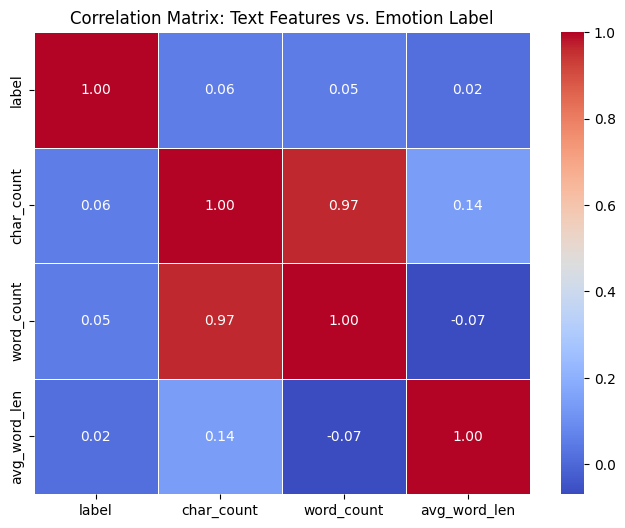

In [140]:
numeric_features = train_df[['label', 'char_count', 'word_count', 'avg_word_len']]
corr_matrix = numeric_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Text Features vs. Emotion Label')
plt.show()

##### Distribution Graphs

C:\Users\Chacha\AppData\Local\Temp\ipykernel_25364\2570528651.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='emotion_name', y='word_count', palette='pastel')


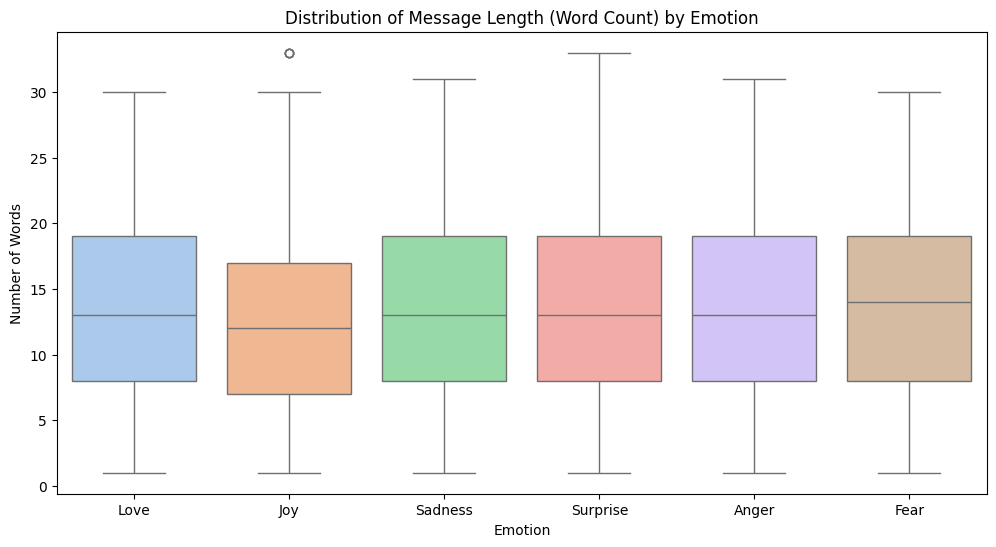

In [141]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='emotion_name', y='word_count', palette='pastel')
plt.title('Distribution of Message Length (Word Count) by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Number of Words')
plt.show()

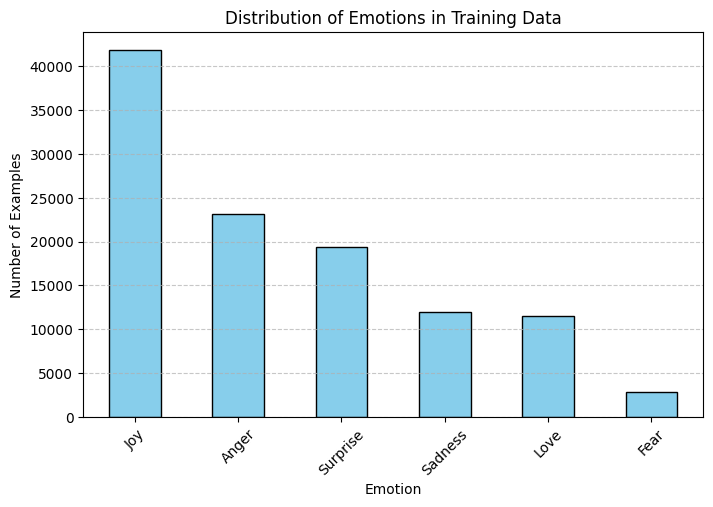

emotion_name
Joy         41812
Anger       23161
Surprise    19396
Sadness     12027
Love        11459
Fear         2893
Name: count, dtype: int64


In [142]:
counts = train_df['emotion_name'].value_counts()

# 2. Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Emotions in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Number of Examples')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()
print(counts)

##### KDE Plot

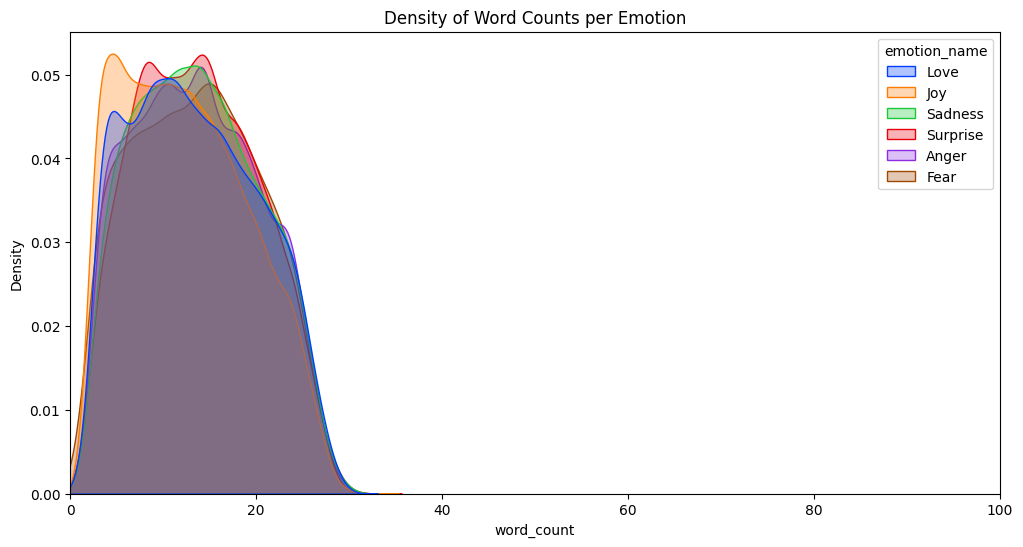

In [143]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=train_df, x='word_count', hue='emotion_name', fill=True, common_norm=False, palette='bright', alpha=0.3)
plt.title('Density of Word Counts per Emotion')
plt.xlim(0, 100) 
plt.show()

# 3. Data Cleaning

In [144]:
# NLTK Downloads
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)


True

In [ ]:
# SETUP STOPWORDS 
stop_words = set(stopwords.words('english'))

# Keep negation words
negation_words = {
    'no', 'not', 'nor', 'neither', 'never', 'none',
    "don't", "aren't", "couldn't", "didn't", "doesn't",
    "hadn't", "hasn't", "haven't", "isn't", "mightn't",
    "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
    "weren't", "won't", "wouldn't", "cannot"
}
stop_words = stop_words - negation_words

# Remove specific noise words
custom_noise = {
    'im', 'wa', 'ha', 'u', 'ur', 'r', 'n', 
    'cause', 'cus', 'cuz', 'tbh', 'idk', 'imo',
    'yall', 'gonna', 'wanna', 'gotta'
}
stop_words.update(custom_noise)

# -CLEANING FUNCTIONS -
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    """
    Preprocesses user input for the model.

    Steps:
    1. Converts text to lowercase.
    2. Expands negations (e.g., "n't" -> " not").
    3. Removes special characters/punctuation.
    4. Lemmatizes words while removing stopwords.

    Args:
        text (str): The raw input string from the user.

    Returns:
        str: The cleaned, lemmatized string ready for vectorization.
    """
    if not isinstance(text, str): return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Handle Negations
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    
    # 3. Remove punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 4. Tokenize & Clean
    words = text.split()
    cleaned_words = []
    for word in words:
        if word not in stop_words:
            pos = get_wordnet_pos(word)
            lemma = lemmatizer.lemmatize(word, pos)
            cleaned_words.append(lemma)
            
    return ' '.join(cleaned_words)

# Application
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)
validation_df['clean_text'] = validation_df['text'].apply(clean_text)

# SAFETY: Drop rows that became empty after cleaning
train_df.dropna(subset=['clean_text'], inplace=True)
test_df.dropna(subset=['clean_text'], inplace=True)
validation_df.dropna(subset=['clean_text'], inplace=True)

# Remove empty strings just in case
train_df = train_df[train_df['clean_text'] != ""]
test_df = test_df[test_df['clean_text'] != ""]
validation_df = validation_df[validation_df['clean_text'] != ""]

# --- 4. VERIFY ---
sample = "I did not pass the exam"
print(f"\nOriginal: '{sample}'")
print(f"Cleaned:  '{clean_text(sample)}'") 



Original: 'I did not pass the exam'
Cleaned:  'not pas exam'


# 4. Vectorization

In [146]:
train_df.dropna(subset=['clean_text'], inplace=True)
test_df.dropna(subset=['clean_text'], inplace=True)
validation_df.dropna(subset=['clean_text'], inplace=True)

print(f"Rows after cleaning: Train={len(train_df)}, Val={len(validation_df)}, Test={len(test_df)}")


# UPGRADE: ngram_range=(1, 3) captures longer phrases like "did not pass"
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 3))

# Learn vocabulary from Training Data ONLY
X_train_vectors = tfidf.fit_transform(train_df['clean_text'])

# Apply the same vocabulary to Test/Validation (Do NOT refit!)
X_test_vectors = tfidf.transform(test_df['clean_text'])
X_val_vectors = tfidf.transform(validation_df['clean_text'])


# Save the Vectorizer (The Translator)
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Save the Matrices (The Numbers)
joblib.dump(X_train_vectors, 'X_train.pkl')
joblib.dump(X_test_vectors, 'X_test.pkl')
joblib.dump(X_val_vectors, 'X_val.pkl')

# Save the Labels (The Answers)
joblib.dump(train_df['label'], 'y_train.pkl')
joblib.dump(test_df['label'], 'y_test.pkl')
joblib.dump(validation_df['label'], 'y_val.pkl')

print(f"Training Matrix Shape: {X_train_vectors.shape}")

Rows after cleaning: Train=110626, Val=13675, Test=13819
Training Matrix Shape: (110626, 15000)


# 5. Model Training and Validation

In [112]:
# LOAD DATA 
if 'X_train_vectors' not in locals():
    print("Loading data from disk...")
    X_train = joblib.load('X_train.pkl')
    y_train = joblib.load('y_train.pkl')
    X_val = joblib.load('X_val.pkl')
    y_val = joblib.load('y_val.pkl')
else:
    print("Using in-memory data...")
    X_train = X_train_vectors
    X_val = X_val_vectors 
    y_train = train_df['label']
    y_val = validation_df['label']

# DEFINE MODELS 
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=10000), 
    "SVM (Linear SVC)": LinearSVC(class_weight='balanced', dual='auto', max_iter=10000)
}

# TRAINING 
results = {}
best_f1 = 0   
best_name = ""
best_model = None

print(f"\n{'Model':<20} | {'Acc':<8} | {'Prec':<8} | {'Rec':<8} | {'F1-Score':<8}")
print("-" * 65)

for name, model in models.items():
    # Train (Fit)
    model.fit(X_train, y_train)
    # Test (Predict)
    pred = model.predict(X_val)
    # Grade
    acc = accuracy_score(y_val, pred)
    # macro avg is vital for imbalance (treats "Surprise" equal to "Joy")
    prec = precision_score(y_val, pred, average='macro', zero_division=0)
    rec = recall_score(y_val, pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, pred, average='macro')
    
    results[name] = f1
    print(f"{name:<20} | {acc:.4f}   | {prec:.4f}   | {rec:.4f}   | {f1:.4f}")
    
    # Pick Winner
    if f1 > best_f1:
        best_f1 = f1
        best_name = name
        best_model = model

print("-" * 65)
print(f"WINNER: {best_name} (F1-Score: {best_f1:.4f})")

# DETAILED REPORT 
print(f"\nDetailed Report for {best_name}:")
target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
print(classification_report(y_val, best_model.predict(X_val), target_names=target_names))



Using in-memory data...

Model                | Acc      | Prec     | Rec      | F1-Score
-----------------------------------------------------------------
Naive Bayes          | 0.5522   | 0.6031   | 0.3752   | 0.3934
Logistic Regression  | 0.5729   | 0.5045   | 0.5714   | 0.5202
SVM (Linear SVC)     | 0.5852   | 0.5043   | 0.5503   | 0.5188
-----------------------------------------------------------------
WINNER: Logistic Regression (F1-Score: 0.5202)

Detailed Report for Logistic Regression:
              precision    recall  f1-score   support

     Sadness       0.41      0.51      0.46      1487
         Joy       0.84      0.63      0.72      5167
        Love       0.43      0.61      0.50      1415
       Anger       0.57      0.52      0.55      2860
        Fear       0.28      0.63      0.39       358
    Surprise       0.49      0.53      0.51      2388

    accuracy                           0.57     13675
   macro avg       0.50      0.57      0.52     13675
weighted avg

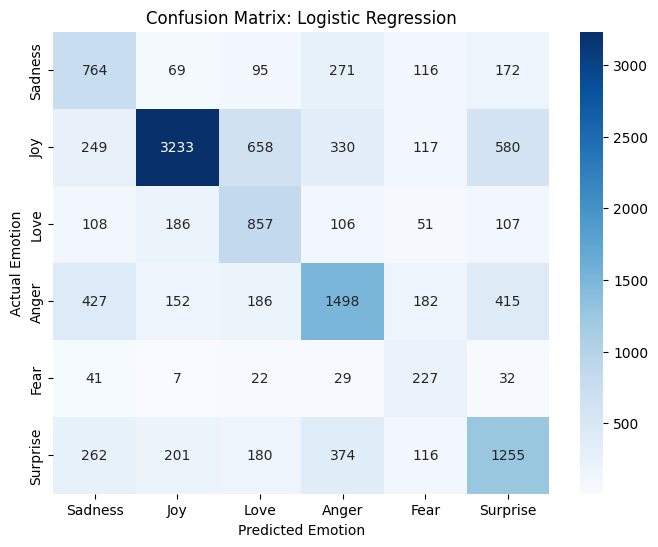

Best model saved.


In [99]:
cm = confusion_matrix(y_val, best_model.predict(X_val))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f"Confusion Matrix: {best_name}")
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.show()

# SAVE WINNER MODEL
joblib.dump(best_model, 'final_best_model.pkl')
print("Best model saved.")

# 6. Model Testing

In [147]:
# Load Model
print("Loading the champion model...")
model = joblib.load('final_best_model.pkl')

if 'X_test_vectors' not in locals():
    X_test = joblib.load('X_test.pkl')
    y_test = joblib.load('y_test.pkl')
else:
    X_test = X_test_vectors
    y_test = test_df['label']

# FINAL PREDICTION 
y_pred = model.predict(X_test)

# NUMERIC REPORT 
final_acc = accuracy_score(y_test, y_pred)
print(f"\nFINAL TEST ACCURACY: {final_acc*100:.2f}%")

target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
print("\nFinal Classification Report: ")
print(classification_report(y_test, y_pred, target_names=target_names))



Loading the champion model...

FINAL TEST ACCURACY: 56.98%

Final Classification Report: 
              precision    recall  f1-score   support

     Sadness       0.43      0.52      0.47      1502
         Joy       0.83      0.62      0.71      5217
        Love       0.42      0.58      0.49      1430
       Anger       0.57      0.52      0.54      2892
        Fear       0.25      0.61      0.36       361
    Surprise       0.49      0.55      0.52      2417

    accuracy                           0.57     13819
   macro avg       0.50      0.56      0.51     13819
weighted avg       0.62      0.57      0.58     13819



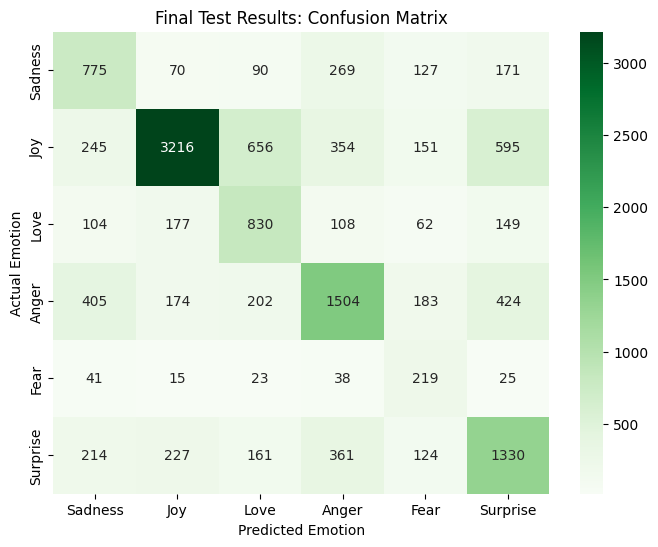

In [109]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.title('Final Test Results: Confusion Matrix')
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.show()

### Model Saving

In [103]:
import joblib
print(f"Saving the winner: {best_name}...")
joblib.dump(best_model, 'final_best_model.pkl')

if 'tfidf' in locals():
    joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
    print("Vectorizer saved successfully!")
else:
    print("Warning: 'tfidf' variable not found. Make sure you ran the Vectorization step!")


Saving the winner: Logistic Regression...
Vectorizer saved successfully!
